###What this is

A simple basic BERT classification model. For use as baseline.

This notebook has been tested and run on Google Colab. SUTD GPU cluster does not work due to package version issues.

Mount drive and change directory to file if need to.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/hate_speech

/content/drive/MyDrive/hate_speech


In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 8.6 MB/s 
     |████████████████████████████████| 636 kB 51.9 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 3.3 MB 57.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import csv
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset

Fixed random seed for reproducibility



In [ ]:
import random

my_seed = 79
random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

In [5]:
df = pd.read_csv('train_hatespeech.csv')
df.set_index('id', inplace = True)
print(df.Label.value_counts())

none      8747
sexism    2534
racism    1548
Name: Label, dtype: int64


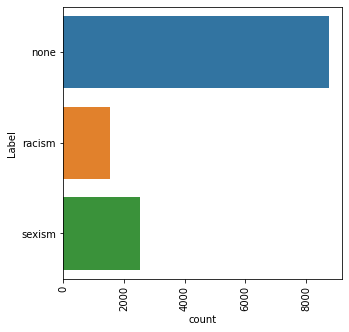

In [6]:
import seaborn as sns
plt.figure(figsize=(5,5))
plt.xticks(rotation=90)
sns.countplot(y="Label", data=df)

As we see, this dataset is quite unbalanced (over represented None class).

Later on I'll tackle this by using weighted sampling for the training process

In [7]:
unique_labels = df.Label.unique()
label_dict={}
for index, unique_label in enumerate(unique_labels):
  label_dict[unique_label] = index

df['label_id'] = df.Label.replace(label_dict)
df.head()

,Tweets,Label,label_id
id,,,
7281,The jokes and puns are flying free in this cam...,none,0
7282,#MKR Lets see who the producers think are goin...,none,0
7283,Praying Jac and Shaz do well! They're my faves...,none,0
7284,RT @realityraver: Pete Evans the Paleo Capital...,none,0
7285,If Kat and Andre stay tonight I will stop watc...,none,0


Fixed seed for `train_test_split`

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label_id.values,
    test_size = 0.15,
    random_state = 79,
    
)

In [9]:
df ['data_type'] = "notset"

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [10]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].Tweets.values,
    add_special_tokens = True,
    return_attention_mask = True,
    padding = 'longest',
    truncation = True,
    return_tensors = 'pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].Tweets.values,
    add_special_tokens = True,
    return_attention_mask = True,
    padding = 'longest',
    truncation = True,
    return_tensors = 'pt'
)



input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label_id.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label_id.values)

In [12]:
df.head()
df.data_type.value_counts()

train    10904
val       1925
Name: data_type, dtype: int64

In [13]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train,labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val,labels_val)

In [14]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

In [16]:
batch_size = 8

# imbalanced dataset, so we need a weighted sampler

class_sample_count_train = np.array([len(np.where(labels_train == t)[0]) for t in np.unique(labels_train)])
weight_train = 1. / class_sample_count_train
samples_weight_train = np.array([weight_train[t] for t in labels_train])


samples_weight_train = torch.from_numpy(samples_weight_train).double()
sampler_train = WeightedRandomSampler(samples_weight_train, len(samples_weight_train))


dataloader_train = DataLoader(
    dataset_train,
    sampler = sampler_train,
    batch_size = batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = batch_size
)

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

epochs = 3

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(dataloader_train)*epochs
)

In [18]:
from sklearn.metrics import f1_score

In [19]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [20]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v:k for k,v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat == label]
      y_true = labels_flat[labels_flat == label]
      print(f'Class:{label_dict_inverse[label]}')
      print(f'Accuracy:{len(y_preds[y_preds == label])}/{len(y_true)}\n')

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [23]:
def evaluate(model, dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [25]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc = 'Epoch {:1d}'.format(epoch),
                        leave = False,
                        disable = False)
    for batch in progress_bar:

      model.zero_grad()

      batch = tuple(b.to(device) for b in batch)

      inputs = {
          'input_ids': batch[0],
          'attention_mask': batch[1],
          'labels': batch[2]
      }
      outputs = model(**inputs)

      loss = outputs[0]
      loss_train_total += loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
  

      optimizer.step()
      scheduler.step()

      progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
    torch.save(model.state_dict(),f'BERT_ft_epoch{epoch}.model')

    tqdm.write(f'Epoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss:{loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(model, dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss:{val_loss}')
    tqdm.write(f'F1 score (weighted):{val_f1}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1363 [00:00<?, ?it/s]

Epoch 1
Training loss:0.33866900282413837
Validation loss:0.7141244120671727
F1 score (weighted):0.8137554055307792


Epoch 2:   0%|          | 0/1363 [00:00<?, ?it/s]

Epoch 2
Training loss:0.25545578730830365
Validation loss:0.5745764193820663
F1 score (weighted):0.8580009434028606


Epoch 3:   0%|          | 0/1363 [00:00<?, ?it/s]

Epoch 3
Training loss:0.19199429915962374
Validation loss:0.6150705813482419
F1 score (weighted):0.8613375641670966


In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(
    torch.load('BERT_ft_epoch3.model',
               map_location = torch.device('cpu'))
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [27]:
_,predictions, true_vals = evaluate(model, dataloader_val)
print(predictions, true_vals)
accuracy_per_class(predictions, true_vals)

[[-0.82657355  4.373413   -3.6792321 ]
 [ 4.9057555  -2.7002556  -1.8720461 ]
 [-1.5412681  -3.17482     4.8969817 ]
 ...
 [ 0.62081844  3.323526   -4.157451  ]
 [-0.50792605  3.1462348  -2.9568453 ]
 [ 1.063926    3.130642   -4.3681254 ]] [1 0 2 ... 0 0 0]
Class:none
Accuracy:1105/1313

Class:racism
Accuracy:204/233

Class:sexism
Accuracy:333/379

